# Modelo predicción precio viviendas Madrid

# *1. Contexto*

En este proyecto de ciencia de datos, hemos llevado a cabo un análisis detallado de un conjunto de datos de ventas de viviendas en Madrid.Nuestro objetivo es desarrollar un modelo predictivo preciso para estimar los precios de las viviendas. Trs realizar un exhaustivo Análisis Exploratorio de Datos (EDA), hemos obtenido una comprensión profunda de las características y relaciones clave entre las variables. Ahora, nos encontramos en una fase crucial: la construcción, evaluación y selección del modelo más adecuado para la predicción.


# *2. Librerías y configuración*

In [42]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import learning_curve
# Importing ML libraries and metrics
from math import sqrt
from tqdm import tqdm
import lightgbm as lgb
import xgboost as xgb
from lightgbm import early_stopping, log_evaluation
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Importar RFE desde scikit-learn
from sklearn.feature_selection import RFE
from joblib import dump

import shap
import pickle

In [2]:
# Ajusta las opciones de visualización
pd.set_option('display.max_rows', None)  # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# *3. Funciones*

In [3]:
# Función que agrupa las columnas por tipo de dato

def columnas_por_tipo(df):
    # Filtrar columnas por tipo de datos
    int_columns = [col for col in df.columns if df[col].dtype.name.startswith('int')]
    float_columns = [col for col in df.columns if df[col].dtype.name.startswith('float')]
    # Lista de columnas que contienen exclusivamente los valores 0, 1 y NaN
    boolean_columns=[col for col in df.columns if set(df[col].dropna().unique()) <= {0, 1}]
    
    numeric_cols = int_columns + float_columns
    num_nobool = list(set(numeric_cols)-set(boolean_columns))
    object_columns = df.select_dtypes(include='object').columns.tolist()
    category_columns = df.select_dtypes(include='category').columns.tolist()
    cols = df.columns.tolist()

    cat_columns=list(set(category_columns) - set(boolean_columns) )
    # Obtener todas las columnas
    all_columns = set(df.columns)
    # Columnas de otros tipos
    other_columns = list(all_columns - set(int_columns) - set(float_columns) - set(object_columns) - set(category_columns))
    cols_noboolean = set(cols) - set(boolean_columns)

    # Contar el número de columnas de cada tipo
    num_int_columns = len(int_columns)
    num_float_columns = len(float_columns)
    num_object_columns = len(object_columns)
    num_category_columns = len(category_columns)
    num_other_columns = len(other_columns)

    # Mostrar los resultados
    print("Número de columnas de tipo entero:", num_int_columns)
    print("Columnas de tipo entero:", int_columns)
    print("------------------------------------------------------")
    print("Número de columnas de tipo float:", num_float_columns)
    print("Columnas de tipo float:", float_columns)
    print("------------------------------------------------------")
    print("Número de columnas de tipo object:", num_object_columns)
    print("Columnas de tipo object:", object_columns)
    print("------------------------------------------------------")
    print("Número de columnas de tipo category:", num_category_columns)
    print("Columnas de tipo category:", category_columns)
    print("------------------------------------------------------")
    print("Número de columnas de otros tipos:", num_other_columns)
    print("Columnas de otros tipos:", other_columns)

    return boolean_columns, numeric_cols, cat_columns, object_columns, other_columns, num_nobool, cols_noboolean

# *4 Carga de datos*



Para esta fase del proyecto de selección del modelo, trabajamos con dos conjuntos de datos: `train` y `test`. Ambos datasets han sido previamente depurados, eliminando valores nulos y garantizando su limpieza, lo que asegura una calidad de datos óptima para el desarrollo del modelo. Durante la fase de Análisis Exploratorio de Datos (EDA), se llevaron a cabo transformaciones adicionales y un estudio detallado de las variables, identificando patrones, distribuciones y relaciones clave. Este proceso no solo nos permitió comprender mejor los datos, sino también preparar el terreno para las siguientes etapas del modelado. Además, se aplicó la codificación *one-hot encoding* a las variables categóricas para hacerlas aptas para los algoritmos de aprendizaje automático, y se eliminaron variables con alta correlación para reducir la multicolinealidad y optimizar el rendimiento del modelo. Por último, hemos validado que las características seleccionadas tengan relevancia estadística y coherencia con el problema a resolver.



In [4]:
X_train= pd.read_csv('./data/X_train_VC.csv',sep=";",index_col=False)
X_test= pd.read_csv('./data/X_test_VC.csv',sep=";",index_col=False)

In [5]:
X_train.shape,X_test.shape

((7890, 71), (1973, 71))

In [6]:
# Revisamos los datos del dataset
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7890 entries, 0 to 7889
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            7890 non-null   object 
 1   m2_constr                      7890 non-null   float64
 2   estado                         7890 non-null   int64  
 3   amueblado                      7890 non-null   float64
 4   planta                         7890 non-null   float64
 5   codigo_postal                  7890 non-null   int64  
 6   certificado_energetico         7890 non-null   float64
 7   orientacion_este               7890 non-null   float64
 8   orientacion_oeste              7890 non-null   float64
 9   orientacion_sur                7890 non-null   float64
 10  orientacion_norte              7890 non-null   float64
 11  num_personas                   7890 non-null   int64  
 12  total_transacciones            7890 non-null   i

In [7]:
# Identificamos el numero de valores unicos
X_train.nunique()

url                              7890
m2_constr                         526
estado                              6
amueblado                           4
planta                             26
codigo_postal                      49
certificado_energetico              2
orientacion_este                    2
orientacion_oeste                   2
orientacion_sur                     2
orientacion_norte                   2
num_personas                      131
total_transacciones               122
viv_nuevas_transacciones           58
lineas_metro                        8
renta_bruta_media_por_persona      21
tamano_medio_del_hogar             18
tam_hogar                          21
hog_con_10                         21
hog_con_15_y_más                   17
m2_areasverdes                     21
ins_comunitaria                     3
energia                             5
eficiencia_carpinteria              9
precio_mean_b                     131
pm_tlogia_distrito                116
euro_m2_barr

# *5. Análisis de datos*

In [8]:
#Revisamos las estadisticas
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
m2_constr,7890.00,138.90,149.89,10.00,68.00,98.00,150.00,3250.00
estado,7890.00,1.39,1.52,0.00,0.00,1.00,2.00,5.00
amueblado,7890.00,0.10,0.30,0.00,0.00,0.00,0.00,1.00
planta,7890.00,2.59,2.24,-1.00,1.00,2.00,3.00,27.00
codigo_postal,7890.00,28021.26,15.14,28001.00,28009.00,28017.00,28033.00,28055.00
certificado_energetico,7890.00,0.19,0.39,0.00,0.00,0.00,0.00,1.00
orientacion_este,7890.00,0.06,0.24,0.00,0.00,0.00,0.00,1.00
orientacion_oeste,7890.00,0.05,0.21,0.00,0.00,0.00,0.00,1.00
orientacion_sur,7890.00,0.08,0.27,0.00,0.00,0.00,0.00,1.00
orientacion_norte,7890.00,0.03,0.18,0.00,0.00,0.00,0.00,1.00


## *5.1 Distribución de la variable objetivo (target)*

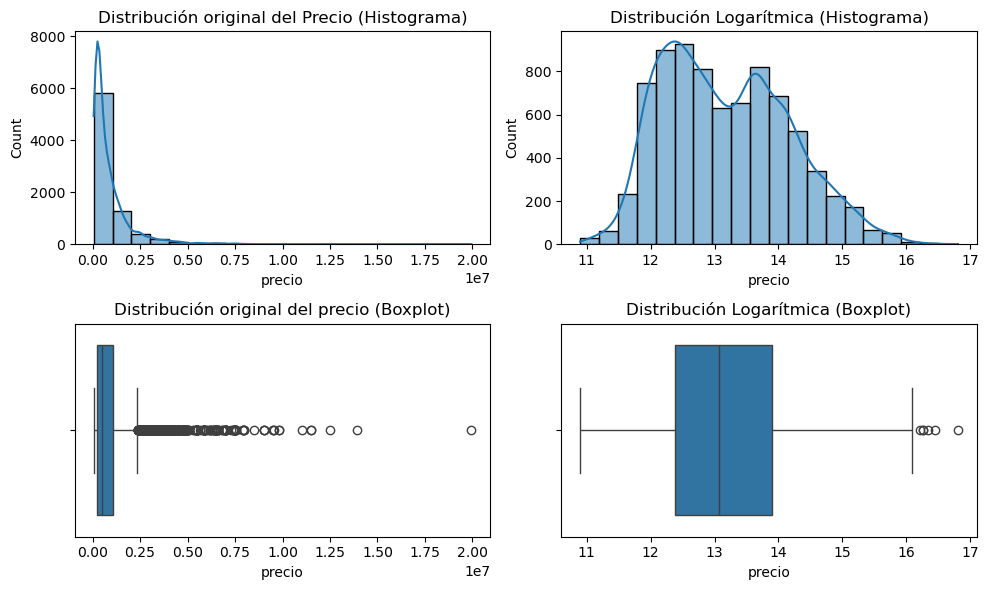

In [9]:
# Crear una figura con 2 filas y 2 columnas para los gráficos
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Primer gráfico: Histograma de la distribución original
sns.histplot(X_train["precio"], bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribución original del Precio (Histograma)")

# Segundo gráfico: Histograma de la distribución logarítmica
sns.histplot(np.log1p(X_train["precio"]), bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribución Logarítmica (Histograma)")

# Tercer gráfico: Boxplot de la distribución original
sns.boxplot(x=X_train["precio"], ax=axes[1, 0])
axes[1, 0].set_title("Distribución original del precio (Boxplot)")

# Cuarto gráfico: Boxplot de la distribución logarítmica
sns.boxplot(x=np.log1p(X_train["precio"]), ax=axes[1, 1])
axes[1, 1].set_title("Distribución Logarítmica (Boxplot)")

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()

La transformación logaritmica suaviza considerablemente la distribución de la variable precio.

Aplicamos la transformación logaritmica a la variable para entrenar el modelo

Revisamos la correlación entre las variables

In [10]:
# Finding out the correlation between the features
#quitamos url
corr =  X_train.drop(columns=['url']).corr()

<Axes: >

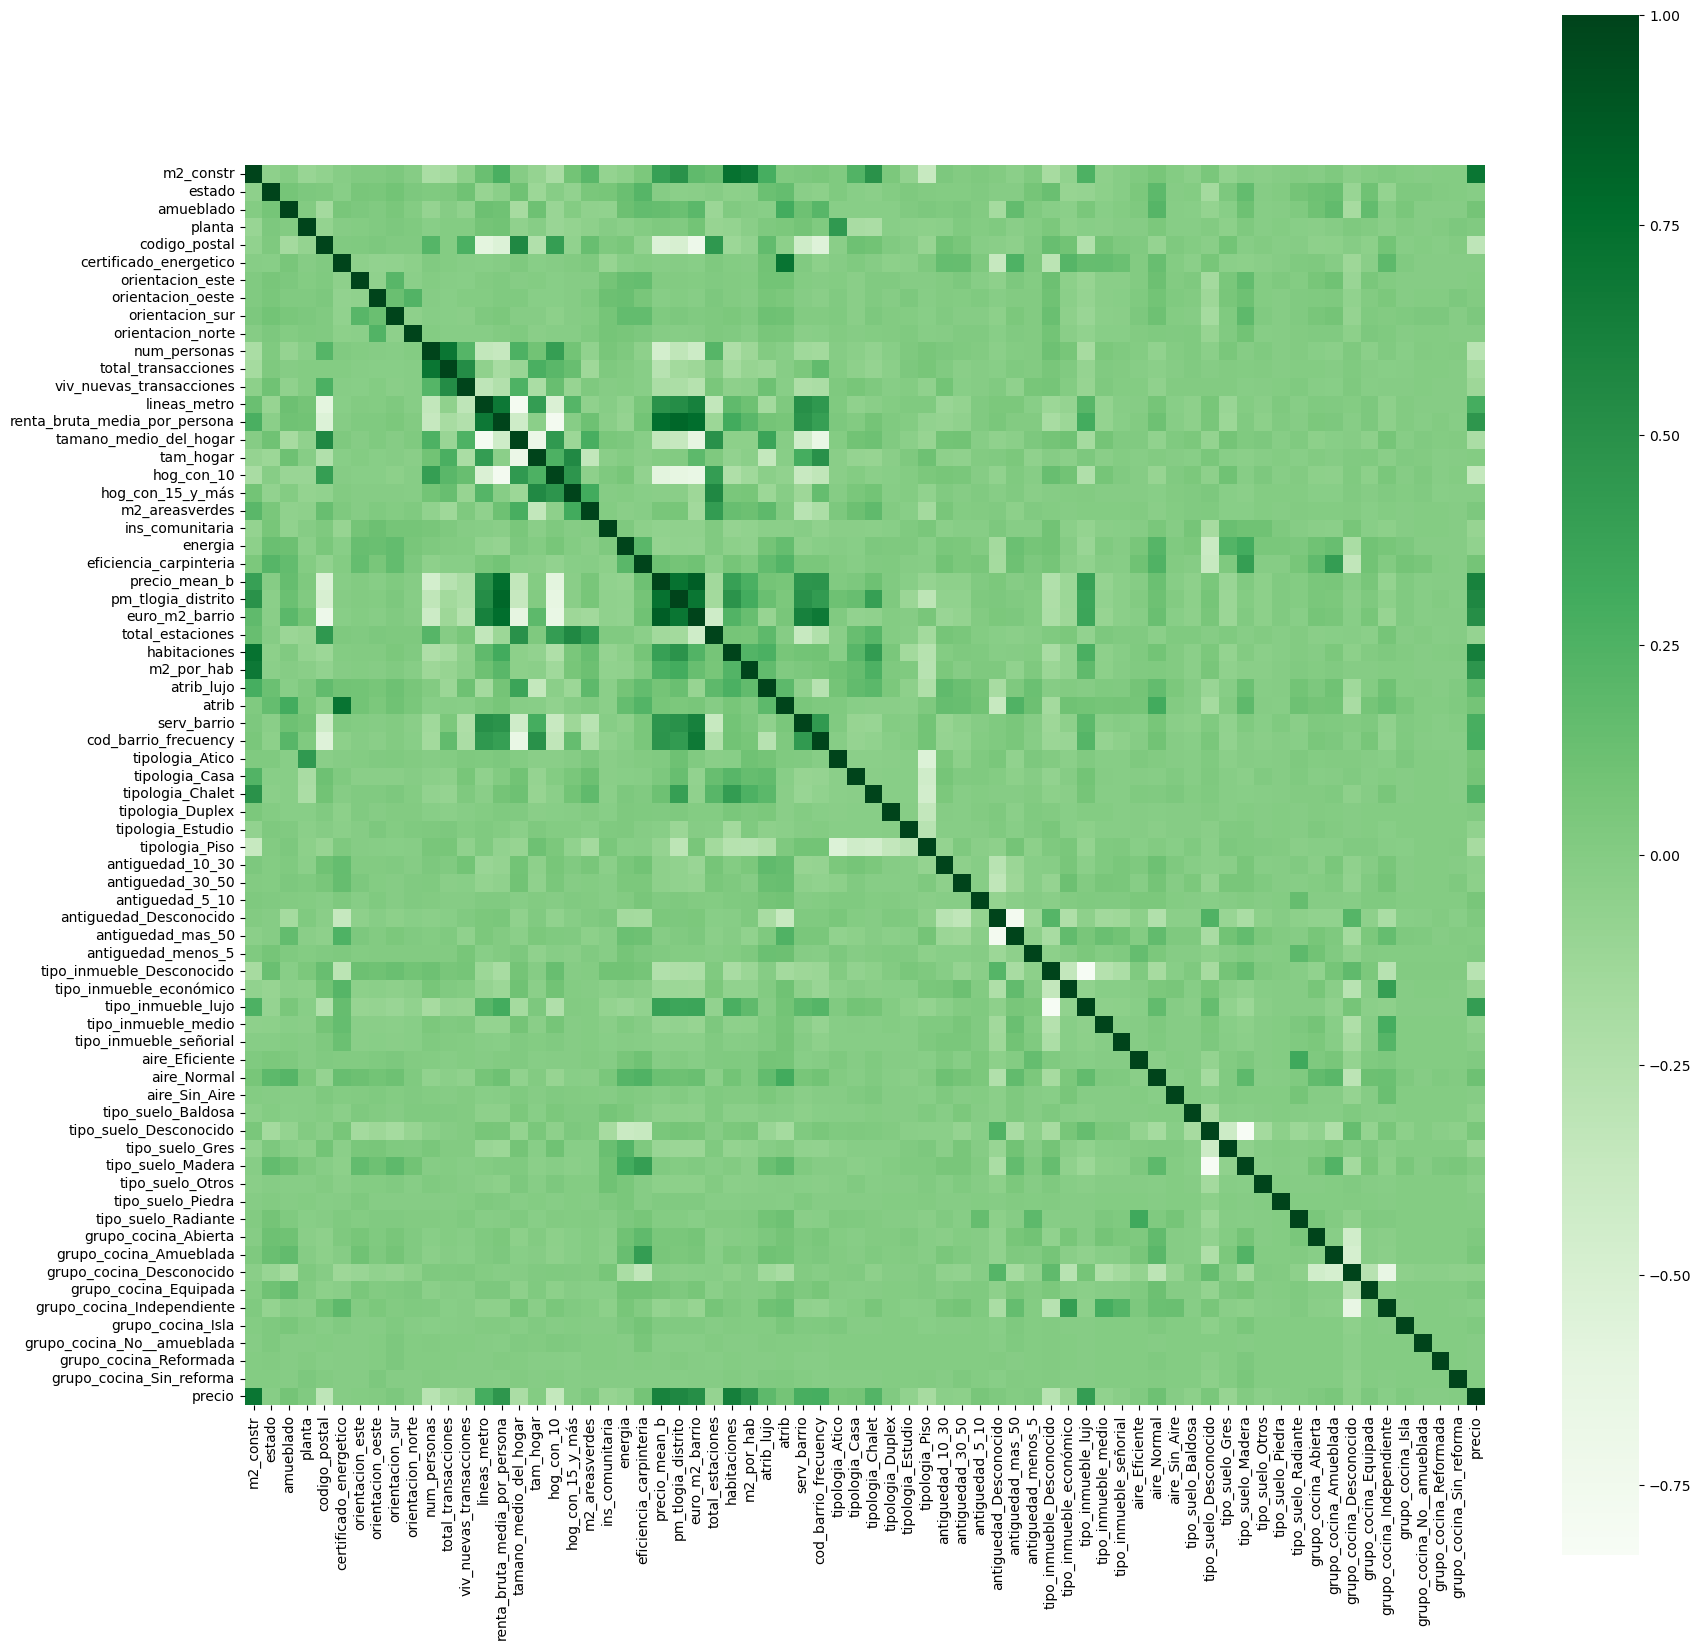

In [11]:
# Plotting the heatmap of correlation between features
plt.figure(figsize=(20,20))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=False, annot_kws={'size':15}, cmap='Greens')

Comprobamos la correlacción de todas las varibles con la varaible objetivo

In [12]:
corr[['precio']].sort_values(by = 'precio',ascending = False).style.background_gradient()

,precio
precio,1.000000
m2_constr,0.703756
habitaciones,0.630717
precio_mean_b,0.607089
pm_tlogia_distrito,0.569682
euro_m2_barrio,0.516803
m2_por_hab,0.463011
renta_bruta_media_por_persona,0.458170
tipo_inmueble_lujo,0.406937
lineas_metro,0.296938


Comprobamos si hay variables muy correladas que aporten la misma infrmación al modelo para  eliminar al menos una de ellas

In [13]:
# Establecer un umbral para la correlación (90%)
threshold = 0.90

# Identificar pares de variables con correlación
correlations = []
already_seen = set()

for col in corr.columns:
    for row in corr.index:
        if abs(corr.loc[row, col]) > threshold and col != row:
            pair = tuple(sorted((row, col)))  # Crear pares únicos
            if pair not in already_seen:
                correlations.append((row, col, corr.loc[row, col]))
                already_seen.add(pair)  # Marcar par como ya visto

# Imprimir los resultados
print("Pares de variables con correlación mayor al 90%:")
for var1, var2, corr in correlations:
    print(f"{var1} y {var2}: {corr:.2f}")


Pares de variables con correlación mayor al 90%:


## 5.2 Extracción de la variable target en train / test

In [14]:
X_train['precio'].head()

0    410000.00
1   1149000.00
2   1175000.00
3   4500000.00
4    318900.00
Name: precio, dtype: float64

In [15]:
X_train.columns

Index(['url', 'm2_constr', 'estado', 'amueblado', 'planta', 'codigo_postal',
       'certificado_energetico', 'orientacion_este', 'orientacion_oeste',
       'orientacion_sur', 'orientacion_norte', 'num_personas',
       'total_transacciones', 'viv_nuevas_transacciones', 'lineas_metro',
       'renta_bruta_media_por_persona', 'tamano_medio_del_hogar', 'tam_hogar',
       'hog_con_10', 'hog_con_15_y_más', 'm2_areasverdes', 'ins_comunitaria',
       'energia', 'eficiencia_carpinteria', 'precio_mean_b',
       'pm_tlogia_distrito', 'euro_m2_barrio', 'total_estaciones',
       'habitaciones', 'm2_por_hab', 'atrib_lujo', 'atrib', 'serv_barrio',
       'cod_barrio_frecuency', 'tipologia_Atico', 'tipologia_Casa',
       'tipologia_Chalet', 'tipologia_Duplex', 'tipologia_Estudio',
       'tipologia_Piso', 'antiguedad_10_30', 'antiguedad_30_50',
       'antiguedad_5_10', 'antiguedad_Desconocido', 'antiguedad_mas_50',
       'antiguedad_menos_5', 'tipo_inmueble_Desconocido',
       'tipo_inmuebl

* Guardamos en un dataset dfids la identificación de cada viviendas
* Separamos los conjunto de datos de la caracteristica y la variable a predecir

In [16]:
df_ids = X_train[['url']]
y_train=X_train['precio']
y_test=X_test['precio']
X_train = X_train.drop(columns=["url","precio"])
X_test = X_test.drop(columns=["url","precio"])


In [17]:
X_train.columns

Index(['m2_constr', 'estado', 'amueblado', 'planta', 'codigo_postal',
       'certificado_energetico', 'orientacion_este', 'orientacion_oeste',
       'orientacion_sur', 'orientacion_norte', 'num_personas',
       'total_transacciones', 'viv_nuevas_transacciones', 'lineas_metro',
       'renta_bruta_media_por_persona', 'tamano_medio_del_hogar', 'tam_hogar',
       'hog_con_10', 'hog_con_15_y_más', 'm2_areasverdes', 'ins_comunitaria',
       'energia', 'eficiencia_carpinteria', 'precio_mean_b',
       'pm_tlogia_distrito', 'euro_m2_barrio', 'total_estaciones',
       'habitaciones', 'm2_por_hab', 'atrib_lujo', 'atrib', 'serv_barrio',
       'cod_barrio_frecuency', 'tipologia_Atico', 'tipologia_Casa',
       'tipologia_Chalet', 'tipologia_Duplex', 'tipologia_Estudio',
       'tipologia_Piso', 'antiguedad_10_30', 'antiguedad_30_50',
       'antiguedad_5_10', 'antiguedad_Desconocido', 'antiguedad_mas_50',
       'antiguedad_menos_5', 'tipo_inmueble_Desconocido',
       'tipo_inmueble_econó

In [18]:
# Ajustar las configuraciones de pandas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.expand_frame_repr', False)  # Evitar el ajuste a nuevas líneas

# *7. Entrenamiento*

Para analizar cual es el modelo que mejor predice nuestra variable objetivo (" precio") vamos a entrenar varios modelos de regresión y elegiremos aquel que no de el mayor R2, ya que es la metrica que vamos a utilizar para evaluar el modelo.


Los modelos que vamos a probar son:

**Random Forest Regressor:**  modelo basado en un conjunto de árboles de decisión que utiliza bagging para combinar múltiples predicciones y mejorar la precisión.
  - Maneja relaciones no lineales entre variables.
  - Resistente a overfitting si se configura adecuadamente.
  - Proporciona medidas de importancia de las características (`feature_importances_`).

**Gradient Boosting Regressor:** modelo basado en árboles de decisión que construye árboles de manera secuencial, donde cada nuevo árbol corrige los errores del anterior.
  - Funciona bien con datos no lineales.
  - Es sensible a hiperparámetros como `learning_rate` y `n_estimators`.
  - Puede ajustarse para evitar overfitting utilizando técnicas como regularización.

**XGBoost Regressor:**- Es una implementación avanzada de Gradient Boosting que optimiza la velocidad y el rendimiento del modelo.
  - Soporta regularización (`L1` y `L2`), lo que mejora la generalización.
  - Utiliza técnicas como paralelización y manejo eficiente de memoria.

**LGBM Regressor (LightGBM):** modelo de boosting basado en histogramas que divide los datos en "hojas" en lugar de niveles, lo que mejora la velocidad.
  - Altamente eficiente y rápido para grandes conjuntos de datos.
  - Soporta múltiples hiperparámetros para ajustar la profundidad y el número de hojas.
  - Maneja datos categóricos directamente.



##### *Selección de hiperparametros*

In [19]:

# Lista de modelos y sus hiperparámetros
models_params = {    
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [50, 100, 200, 300],
            #"max_depth": [None, 10, 20, 30],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10,20],
            "min_samples_leaf": [10, 20]
           # "min_samples_leaf": [1, 2,4]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": [50, 100, 200,300],
            "learning_rate": [0.001,0.01, 0.05, 0.1],
            "max_depth": [3, 4, 5],
            "min_samples_leaf": [10, 20],
            "subsample": [0.6,0.7, 0.8]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            "n_estimators": [100, 200,300,400,500],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "max_depth": [3, 4, 5, 6],
            "subsample": [0.6,0.7, 0.8, 0.9, 1.0]
        }
    },
    "LGBM Regressor": {
        "model": lgb.LGBMRegressor(),
        "params": {        
            'n_estimators': np.arange(50, 300, 50),
            'learning_rate': [0.001,0.01, 0.05,0.08],
            'max_depth': [4,6, 8],
            'num_leaves': [8,10, 15, 20],
            'min_child_samples': [10, 15, 20],
            'subsample': [0.5, 0.6, 0.7,0.8]
        }
    }
    }

##### Entrenamamiento con hiperparametros y validación cruzada 

Iteramos sobre los modelos y los hiperparametros y con RandomizedSearchCV se realiza una búsqueda aleatoria de hiperparámetros en el espacio definido por param_dist

Seleccionamos 4 particiones para hacer la validación cruzada,  30 combinaciones de hiperparametros a probar.

Especificamos uque la metris de evaluación sea "r2" y indicamos que se ajuste  automáticamente el modelo con los mejores hiperparámetros

El modelo resultante se entrena  usando los datos de entrenamiento.

Los resultados detallados como las combinaciones de hiperparámetros probadas y sus respectivas métricas, se almacenan en un DataFrame creado
 a partir de random_search.cv_results_. También se añade una columna extra (regressor) para identificar a qué modelo pertenecen esos resultados.
Este DataFrame se agrega a la lista random_search_output
El modelo con los mejores hiperparámetros para cada algoritmo (obtenido con random_search.best_estimator_) se guarda en el diccionario best_estimators bajo el nombre del modelo.

Entradas: Conjunto de datos (X_train, y_train), lista de modelos y sus hiperparámetros.

Procesamiento:

*Se realiza validación cruzada con RandomizedSearchCV.

*Se evalúan varias combinaciones de hiperparámetros.

*Se identifica y almacena el modelo con los mejores resultados.

Salidas:

*Resultados detallados en random_search_output.

*Modelos ajustados con los mejores hiperparámetros en best_estimators.

Al tener unas columnas valores muy grandes y otras muy pequeños vamos a normalizar para que el modelo no dé mas peso a las primeras.Al normalizar, llevamos todas las variables a una escala similar.
Dentro de las opciones que tenemos para normalizar , utilizamos RobustScaler para reducir el impacto de los outliers, ya que es especialmente útil porque utiliza la mediana y el rango intercuartílico (IQR) para escalar los datos

In [20]:

# Aplicar transformación logarítmica a la variable target antes de escalar

# Aplicar logaritmo a los valores escalados
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Entrenar el modelo con los valores logarítmicos


# Normalizar características con RobustScaler
scaler_X = RobustScaler().set_output(transform="pandas")
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)


# Función para calcular el RAE
def relative_absolute_error(y_true, y_pred):
    abs_error = np.sum(np.abs(y_true - y_pred))
    abs_mean_error = np.sum(np.abs(y_true - np.mean(y_true)))
    return abs_error / abs_mean_error

# Diccionarios para almacenar resultados
metrics = {}
cv_results = {}
feature_importance_dict = {}
random_search_output = list()
best_estimators = {}

# Validación cruzada con KFold y búsqueda de hiperparámetros
for name, info in models_params.items():
    print(name)
    model = info["model"]
    param_dist = info["params"]
    
    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        model, param_dist, cv=4, n_iter=30, 
        scoring="r2", random_state=42, n_jobs=-1, return_train_score=True, verbose=1, refit=True
    )
    random_search.fit(X_train_scaled, y_train_log)
    
    # Resultados del Random Search
    df_output = pd.DataFrame(random_search.cv_results_)
    df_output['regressor'] = name
    random_search_output.append(df_output)
    
    # Modelo re-entrenado con los hiperparámetros óptimos
    best_estimators[name] = random_search.best_estimator_
    
    # Predicciones en conjunto de test
    y_pred_log= random_search.best_estimator_.predict(X_test_scaled)   


Random Forest
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Gradient Boosting
Fitting 4 folds for each of 30 candidates, totalling 120 fits
XGBoost
Fitting 4 folds for each of 30 candidates, totalling 120 fits
LGBM Regressor
Fitting 4 folds for each of 30 candidates, totalling 120 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 7890, number of used features: 64
[LightGBM] [Info] Start training from score 13.179506


Concatenamos todos los resultado para cada modelo, como resultado obtenemos un DataFrame .

Componemos el dataframe df_results con las siguietes columnas:

'regressor': Identifica el modelo o regresor asociado con los resultados.

'rank_test_score': Rango del modelo basado en sus puntajes de validación cruzada (mejor modelo tendrá rango 1).

'mean_train_score': Puntaje promedio en los datos de entrenamiento (valores obtenidos durante la validación cruzada).

'mean_test_score': Puntaje promedio en los datos de prueba.

'std_test_score': Desviación estándar de los puntajes en los datos de prueba.

'params': Detalles de los hiperparámetros evaluados.

split_test_score_columns: Agrega las columnas específicas para los puntajes individuales por partición de la validación cruzada.

##### Dataframe unificado con el resultado de los modelos

In [21]:
# Contatenamos todos los resultados para cada modelo
df_results = pd.concat(random_search_output).reset_index(drop = True)
#split_test_score_columns = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']
#Definimosuna lista con las columnas de la puntuación de la validación cruzada por partición (split0_test_score, split1_test_score, etc.).
#Estas columnas contienen las métricas evaluadas (en este caso, el coeficiente de determinación R^2) en cada partición del proceso de validación cruzada
split_test_score_columns = ['split0_test_score', 'split1_test_score', 'split2_test_score']
df_results = df_results[
    ['regressor', 'rank_test_score', 'mean_train_score', 'mean_test_score', 'std_test_score', 'params']
    + split_test_score_columns
]
df_results.sample(20)

,regressor,rank_test_score,mean_train_score,mean_test_score,std_test_score,params,split0_test_score,split1_test_score,split2_test_score
57,Gradient Boosting,11,0.91,0.91,0.01,"{'subsample': 0.6, 'n_estimators': 100, 'min_s...",0.90,0.91,0.91
90,LGBM Regressor,27,0.32,0.32,0.00,"{'subsample': 0.8, 'num_leaves': 10, 'n_estima...",0.32,0.32,0.32
53,Gradient Boosting,1,0.96,0.92,0.00,"{'subsample': 0.7, 'n_estimators': 300, 'min_s...",0.92,0.93,0.93
97,LGBM Regressor,8,0.92,0.91,0.01,"{'subsample': 0.5, 'num_leaves': 20, 'n_estima...",0.90,0.91,0.92
84,XGBoost,30,0.73,0.73,0.01,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",0.72,0.73,0.73
110,LGBM Regressor,12,0.90,0.89,0.01,"{'subsample': 0.5, 'num_leaves': 15, 'n_estima...",0.88,0.90,0.90
15,Random Forest,26,0.92,0.90,0.01,"{'n_estimators': 200, 'min_samples_split': 10,...",0.89,0.91,0.91
16,Random Forest,12,0.94,0.91,0.01,"{'n_estimators': 50, 'min_samples_split': 20, ...",0.90,0.92,0.92
50,Gradient Boosting,3,0.95,0.92,0.01,"{'subsample': 0.6, 'n_estimators': 100, 'min_s...",0.92,0.93,0.93
58,Gradient Boosting,17,0.76,0.75,0.01,"{'subsample': 0.6, 'n_estimators': 100, 'min_s...",0.75,0.75,0.76


##### Elección del mejor modelo
Para cada modelo seleccionamosel que obtuvo la mejor evaluación (primer lugar) en la validación cruzada segun la metrica R2

In [22]:
pd.set_option('display.max_colwidth', None) 

In [23]:

# Nos quedamos con el mejor modelo de cada tipo
df_best = (
    df_results
    .query('rank_test_score == 1')
    .drop_duplicates(['regressor', 'rank_test_score'])
    .sort_values('mean_test_score', ascending = False)
    .reset_index(drop = True)
)
df_best

,regressor,rank_test_score,mean_train_score,mean_test_score,std_test_score,params,split0_test_score,split1_test_score,split2_test_score
0,Gradient Boosting,1,0.96,0.92,0.00,"{'subsample': 0.7, 'n_estimators': 300, 'min_samples_leaf': 20, 'max_depth': 5, 'learning_rate': 0.1}",0.92,0.93,0.93
1,XGBoost,1,0.97,0.92,0.00,"{'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1}",0.92,0.92,0.93
2,LGBM Regressor,1,0.94,0.92,0.00,"{'subsample': 0.5, 'num_leaves': 15, 'n_estimators': 250, 'min_child_samples': 10, 'max_depth': 6, 'learning_rate': 0.05}",0.92,0.93,0.93
3,Random Forest,1,0.94,0.91,0.01,"{'n_estimators': 300, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 20}",0.90,0.92,0.92


In [24]:
##### Boxplot de la distribución de los puntuajes r2 en cada segmento de la validación cruzada

Extraemos las columnas definidas en split_test_score_columns del DataFrame df_best.
Estas columnas contienen los puntajes de validación cruzada (por ejemplo, split0_test_score, split1_test_score, etc.) para cada modelo
Creamos un boxplot que muestra la distribución de los puntajes r2 es decir qué tan bien el modelo es capaz de realizar predicciones, en comparación con los valores reales, para los modelos en cada partición de la validación cruzada.
Este boxplot de los puntajes R² permite visualizar gráficamente cómo varían los resultados del modelo para cada partición durante la validación cruzada.


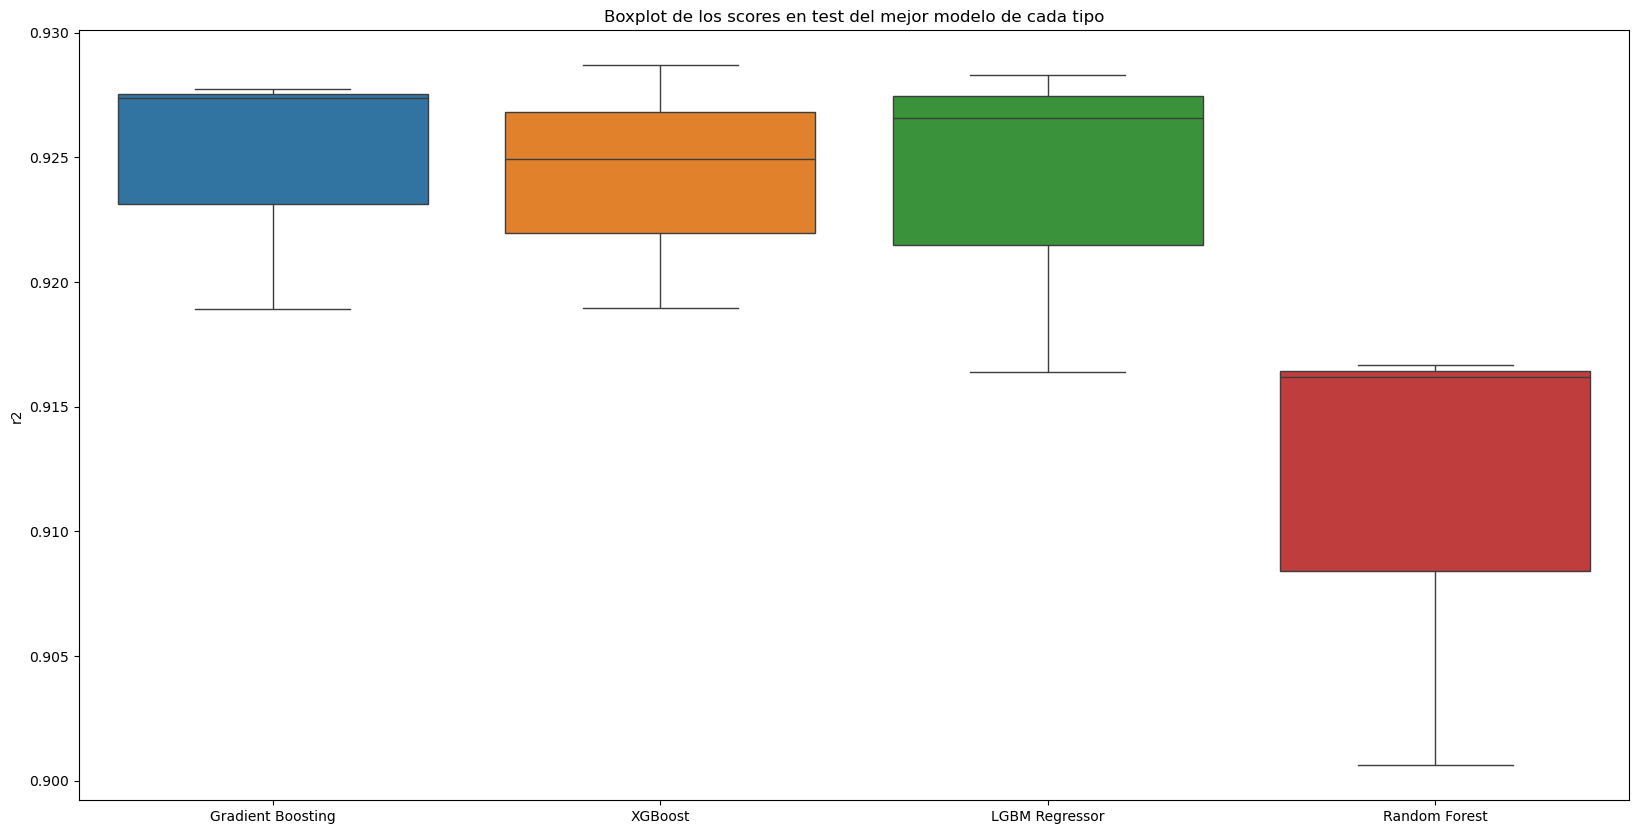

In [25]:
# Transponer el DataFrame para que cada modelo sea una columna
df_transposed = df_best[split_test_score_columns].T

# Crear el boxplot usando Seaborn
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_transposed)
plt.ylabel("r2")

plt.title("Boxplot de los scores en test del mejor modelo de cada tipo")
# Añadir etiquetas al eje x
plt.xticks(ticks=range(len(df_transposed.columns)), labels=df_best["regressor"])
plt.show()

Como podemos observar en caso de XGBoost, LGBM Regressor y Gradient Boosting son los modelos en los que los  valores de R² están cerca de 1, lo que significa que el modelo realiza predicciones precisas en comparación con los valores reales.

La consistencia del modelo: La distribución de los puntajes (rango de la caja y presencia de outliers) muestra si el modelo es estable en diferentes particiones de los datos.

Comparación entre modelos: Al observar los boxplots de diferentes modelos, puedes identificar cuál tiene una mejor precisión promedio y menor variabilidad.

Este análisis es útil para elegir el modelo más adecuado antes de aplicar el sistema predictivo en un entorno real. Es una forma clara de representar qué tan bien los modelos están aprendiendo de los datos

In [26]:
for i, r in df_best.iterrows():
    print(r.regressor, "=>", np.round(r.mean_test_score, 4), "\u00B1", np.round(r.std_test_score, 4))

Gradient Boosting => 0.9231 ± 0.0045
XGBoost => 0.923 ± 0.0041
LGBM Regressor => 0.9227 ± 0.0049
Random Forest => 0.9088 ± 0.0077


##### Elección del mejor modelo y calculo de métricas

In [27]:
# Escogemos el mejor modelo de todos 
#best_model= best_estimators['Gradient Boosting']
best_model= best_estimators['XGBoost']

In [28]:
# Revertir la transformación logarítmica para obtener las predicciones en la escala original
y_pred = np.expm1(y_pred_log)

# Revertir la transformación logarítmica para los valores reales en el conjunto de test
y_test= np.expm1(y_test_log)

# R² en la escala original
r2_original = r2_score(y_test, y_pred)
print("R² en la escala original:", r2_original)


R² en la escala original: 0.7459674948734212


In [29]:


# R² en la escala original
r2_log = r2_score(y_test_log, y_pred_log)
print("R² en la escala logaritmica:", r2_log)

r2_log1 = r2_score(y_test_log, best_model.predict(X_test_scaled))  # En escala logarítmica
print(f"R² en escala logarítmica: {r2_log1:.4f}")



R² en la escala logaritmica: 0.9219634648274595
R² en escala logarítmica: 0.9272


In [ ]:
y_pred_log = best_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test_log, y_pred_log)
mse = mean_squared_error(y_test_log, y_pred_log)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_log, y_pred_log)
rae = relative_absolute_error(y_test_log, y_pred_log)
# Buscar la clave asociada con el best_model
nombre_modelo = next((name for name, model in best_estimators.items() if model == best_model), None)
    
print(f"Metrics for {nombre_modelo}:")
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}, RAE: {rae}")

Metrics for XGBoost:
MAE: 0.1912433252264476, MSE: 0.06901027326663815, RMSE: 0.26269806483230546, R2: 0.927166912896233, RAE: 0.23461145119080762


Como R2 en escala logaritmica es significativamente mayor que en la escala original vamos a utilizar el modelo para predecir en escala logaritmica.
La transformación logarítmica ha ayudado al modelo a capturar patrones que serían difíciles de identificar en la escala original de los datos, es por eso que el modelo tiene un mejor rendimiento en términos de R² cuando se evalúa en esta escala..

##### Importancia de las caracteristicas

Calculamos las caracteristicas más importantes para el modelo a la hora de hacer la predicción

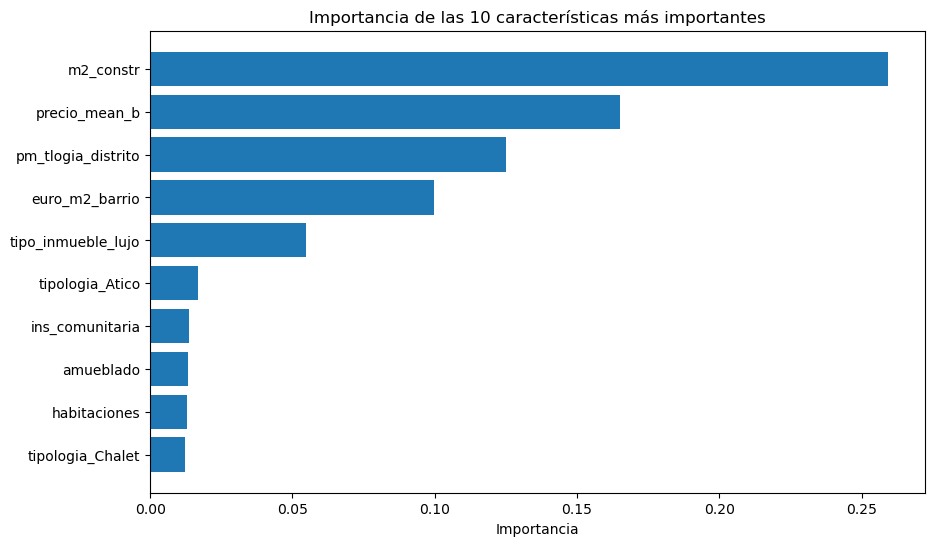

In [30]:
# Obtener la importancia de las características
importances = best_model.feature_importances_

# Ordenar las características por importancia
indices = np.argsort(importances)[::-1]

# Seleccionar las 10 características más importantes
top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_features = X_train.columns[top_indices]

# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances, align="center")
plt.yticks(range(top_n), top_features)
plt.xlabel("Importancia")
plt.title("Importancia de las 10 características más importantes")
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté arriba
plt.show()

##### SHAP

Calculamos el valor que representa la discrepancia entre la predicción del modelo (y_pred_raw) y la suma de los valores SHAP y el valor base.

In [31]:
explainer = shap.TreeExplainer(best_model) # Instanciamos explicador
shap_values = explainer(X_train_scaled) # Se obtienen las explicaciones (SHAP values)
y_pred_raw = best_model.predict(
    X_train_scaled, 
   
)
# Comprobamos que los SHAP values suman las predicciones marginales
np.abs(shap_values.values.sum(axis = 1) + shap_values.base_values - y_pred_raw).max()




1.7166138e-05

Al estar cercano a 0 ,significa que los valores SHAP explican muy bien la predicción del modelo. Es decir, los valores SHAP, cuando se suman con el valor base, se aproximan a la predicción real del modelo (margen de decisión).
Por tanto la explicación del modelo (mediante SHAP) es coherente con las predicciones que hace el modelo.

Vamos a usar los valores SHAP para explicar el modelo









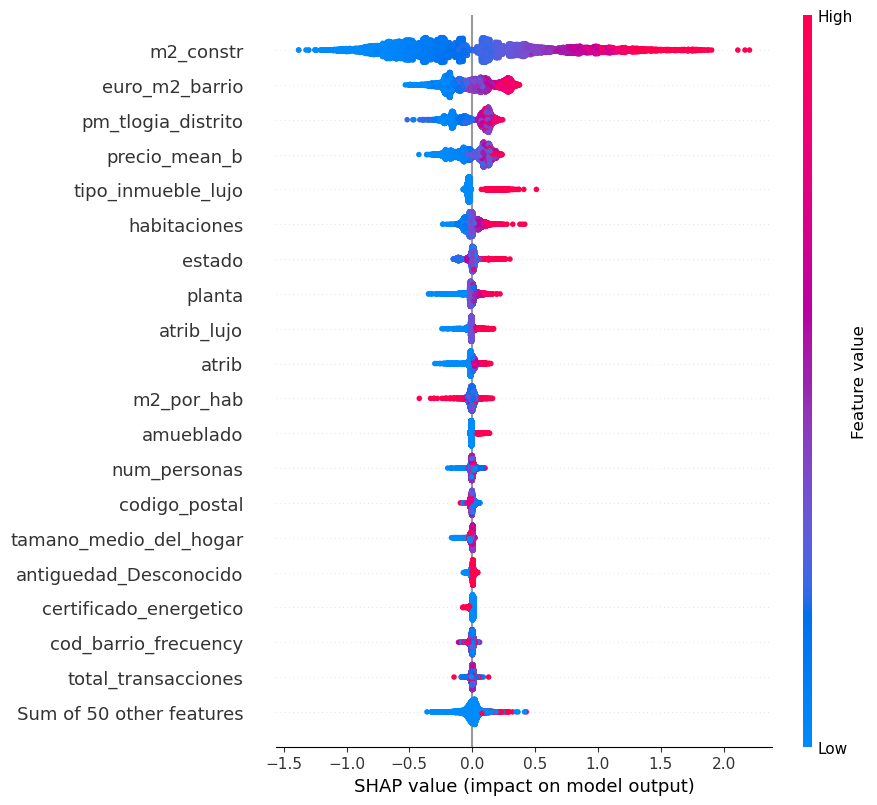

In [32]:
# Gráfico de importancia por variable para cada una de las observaciones
shap.plots.beeswarm(shap_values, max_display = 20)

Cada punto representa una observación (instancia) y muestra cómo una característica específica (en el eje vertical) influye en la predicción del modelo.
  Valores positivos aumentan la predicción.
    Valores negativos disminuyen la predicción.
      Rojo:Valores altos.
        Azul:Valores bajos.

- m2_constr es la característica más influyente en las predicciones del modelo. Valores altos (en rojo) aumentan significativamente las predicciones, mientras que valores bajos (en azul) las disminuyen
  
- euro_m2_barrio:El precio medio del barrio; similar al anterior, afecta directamente las predicciones dependiendo del rango de valores.
    Contribuye significativamente, pero su efecto varía según los valores. Rojo (altos valores) parece tener un impacto negativo, mientras que azul (bajos valores) parece tener un impacto positivo.

- tipo_inmueble_lujo: Una variable categórica que indica si el inmueble es de lujo. Los inmuebles de lujo tienen mayor impacto positivo.

- planta: La planta donde se encuentra el inmueble. Impacta diferente según si está en una planta alta o baja.Las altas impactan positivamente y ls bajas negativamente

Gráfico de Importancia de Características (SHAP Summary)

Características más importantes en la parte superior.
Impacto positivo o negativo de cada característica en las predicciones.

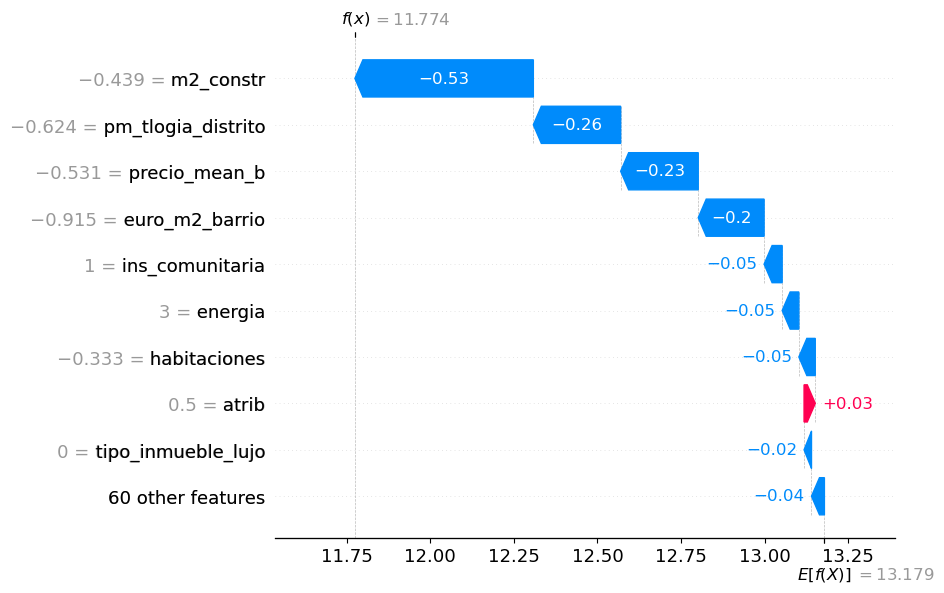

In [33]:
# Gráfico para ver cómo se pasa del explainer.expected_value al model.predict(X)[ind_obs]
ind_obs = 100
shap.plots.waterfall(shap_values[ind_obs])

m2_constr: Tiene un valor de -0.439 y reduce la predicción en -0.54.

precio_mean_b: Valor -0.531, impacto de -0.25.

pm_tlogia_distrito: Valor -0.624, impacto de -0.24.

Revisando las 2 graficas deducimos que valores bajos de m2_contr están reduciendo el desempeño del modelo

##### Gráfico de Predicciones vs Valores Reales: Este gráfico muestra cómo las predicciones del modelo se comparan con los valores reales del conjunto de prueba.

Es útil para detectar patrones, sesgos o errores sistemáticos.

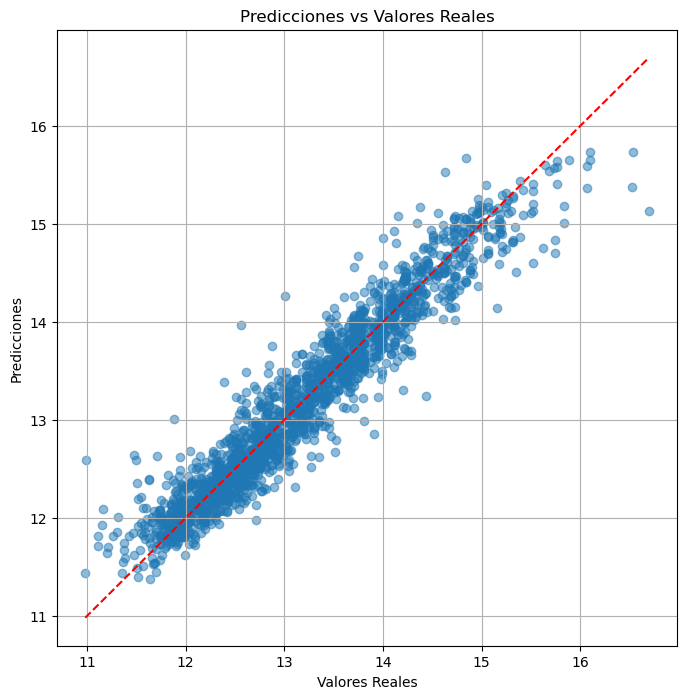

In [34]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test_log, y_pred_log, alpha=0.5)
plt.plot([y_test_log.min(), y_test_log.max()], [y_test_log.min(), y_test_log.max()], 'r--')  # Línea ideal (predicción perfecta)
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.grid()
plt.show()


Los puntos parecen estan bien alineados con la línea roja, lo que sugiere una alta correlación entre las predicciones y los valores reales.



Revertimos el escalado para revisar los outliers en la predicción

2. Gráfico de Errores (Residuals):Analiza la diferencia entre los valores reales y las predicciones (residuales).

Un patrón aleatorio indica que el modelo está bien ajustado, mientras que patrones sistemáticos pueden revelar problemas como sobreajuste o falta de ajuste.

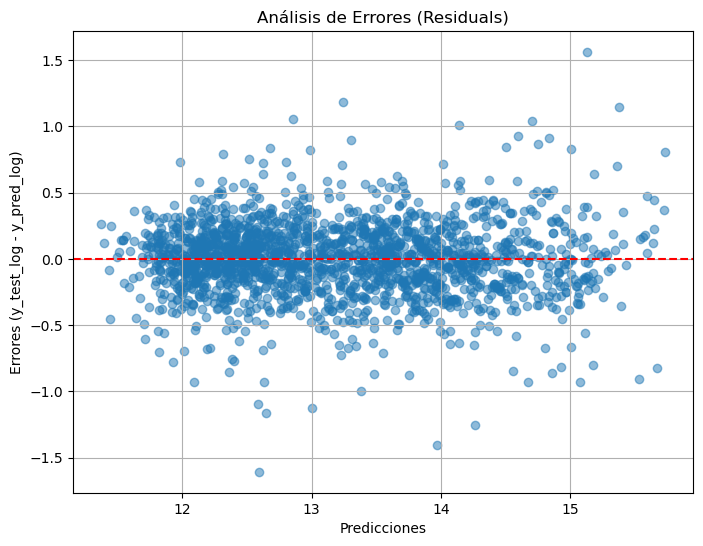

In [35]:
residuals = y_test_log - y_pred_log

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_log, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Análisis de Errores (Residuals)")
plt.xlabel("Predicciones")
plt.ylabel("Errores (y_test_log - y_pred_log)")
plt.grid()
plt.show()


Los residuales deben estar distribuidos uniformemente alrededor de 0.

Patrones claros pueden señalar deficiencias en el modelo.

Distribución de los Errores: Este gráfico muestra la distribución de los errores para evaluar si tienen una forma normal.

En regresión, una distribución simétrica de los errores es deseable.

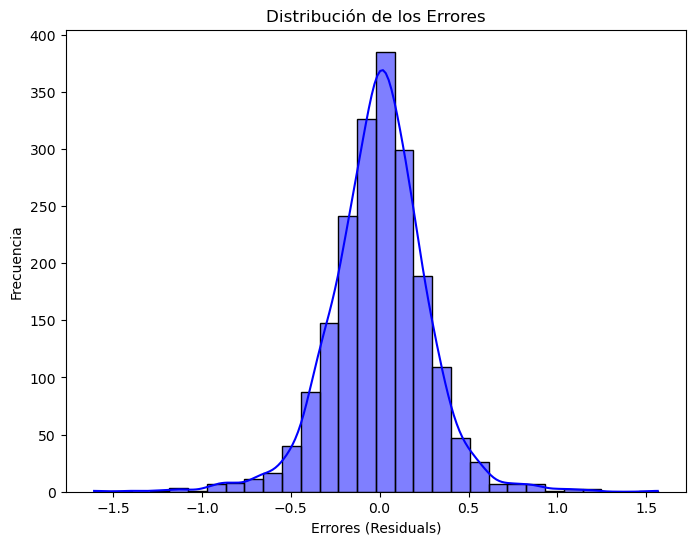

In [36]:


plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.title("Distribución de los Errores")
plt.xlabel("Errores (Residuals)")
plt.ylabel("Frecuencia")
plt.show()


La mayoría de los errores residuales (diferencia entre los valores reales y las predicciones) están concentrados alrededor de 0, lo que sujiere que el modelo está ajustando bien.

In [37]:
# Calcular errores absolutos
errors = np.abs(y_test_log -y_pred_log)

# Crear un DataFrame para analizar
results_df = pd.DataFrame({
    "Valores Reales": y_test_log,
    "Predicciones":y_pred_log,
    "Errores Absolutos": errors
})

# Ordenar por los errores más grandes
results_df_sorted = results_df.sort_values(by="Errores Absolutos", ascending=False)

# Mostrar los datos con mayores errores
print(results_df_sorted.head(10))  # Los 10 datos con mayores errores


      Valores Reales  Predicciones  Errores Absolutos
1816           10.99         12.59               1.61
256            16.69         15.13               1.56
1412           12.56         13.97               1.41
714            13.01         14.26               1.25
1185           14.43         13.25               1.18
968            11.48         12.64               1.16
840            16.52         15.38               1.15
936            11.88         13.00               1.13
1826           11.49         12.59               1.10
529            13.91         12.85               1.06


In [38]:
fila= df_ids.iloc[840]
print(fila)


url    https://www.pisos.com/comprar/piso-virgen_del_cortijo_manoteras28050-25933298715_100500/
Name: 840, dtype: object


In [39]:
fila= df_ids.iloc[714]
print(fila)

url    https://www.indomio.es/anuncios/96524377/
Name: 714, dtype: object


Gráfico de Curva de Aprendizaje:Evalúa cómo varía el desempeño del modelo con respecto al tamaño del conjunto de entrenamiento.

Ayuda a detectar si el modelo tiene problemas de sobreajuste o subajuste.

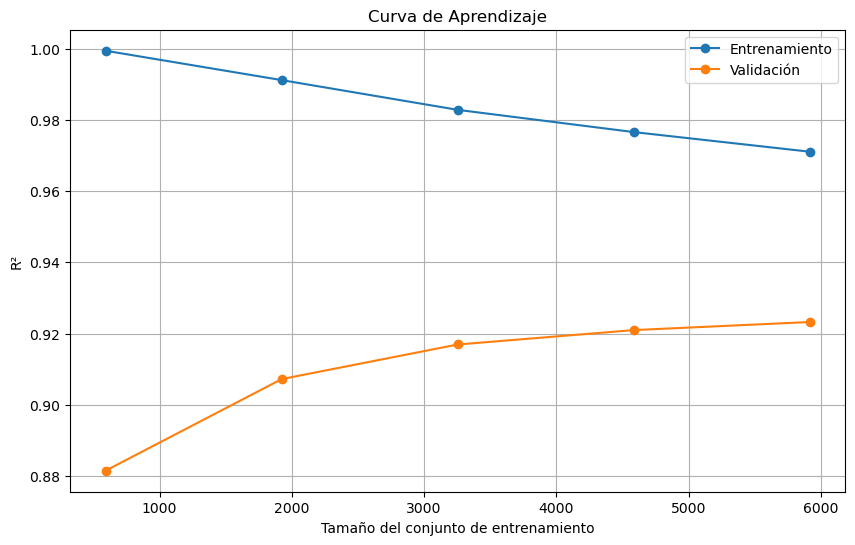

In [40]:


train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train_log, cv=4, scoring="r2", n_jobs=-1
)
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Entrenamiento", marker="o")
plt.plot(train_sizes, test_scores_mean, label="Validación", marker="o")
plt.title("Curva de Aprendizaje")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("R²")
plt.legend()
plt.grid()
plt.show()


La diferencia entre la línea azul y naranja se reduce conforme aumenta el tamaño de entrenamiento, lo que indica que el modelo no está sobreajustando y tiene un buen balance.

##### Guardar el modelo

In [41]:


# 5. Guardar el mejor modelo y el scaler


dump(scaler_X, 'scaler_X.pkl')

final_model = best_model.fit(X_train_scaled, y_train_log)
with open("modelo_final.pkl", "wb") as f:
    pickle.dump(final_model, f)
    # Guardar ambos escaladores



print(f"\nEl modelo final ha sido guardado como 'modelo_final.pkl'.")


NameError: name 'dump' is not defined